**11장 – 심층 신경망 훈련하기**

_이 노트북은 11장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 그레이디언트 소실과 폭주 문제

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


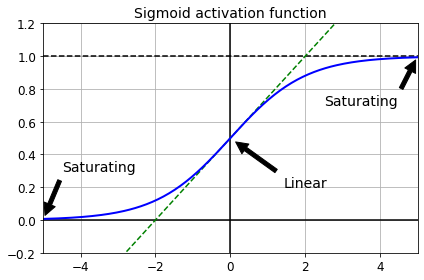

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier 초기화와 He 초기화

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## 수렴하지 않는 활성화 함수

### LeakyReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


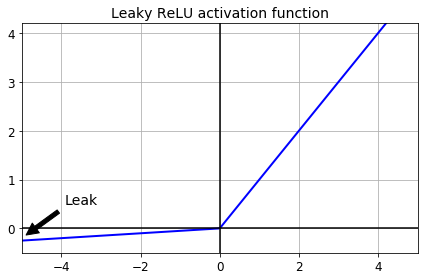

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련해 보죠:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6217 - accuracy: 0.7943 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy:

PReLU를 테스트해 보죠:

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7184
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7880
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8184
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5618 - accuracy: 0.8134 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


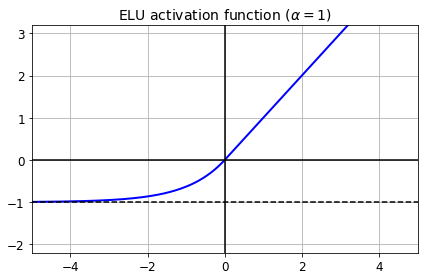

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 쉽게 ELU를 적용할 수 있습니다. 층을 만들 때 활성화 함수로 지정하면 됩니다:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

Günter Klambauer, Thomas Unterthiner, Andreas Mayr는 2017년 한 [훌륭한 논문](https://arxiv.org/pdf/1706.02515.pdf)에서 SELU 활성화 함수를 소개했습니다. 훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화됩니다. 각 층의 출력이 평균과
표준편차를 보존하는 경향이 있습니다. 이는 그레이디언트 소실과 폭주 문제를 막아줍니다. 그 결과로 SELU 활성화 함수는 이런 종류의 네트워크(특히 아주 깊은 네트워크)에서 다른 활성화 함수보다 뛰어난 성능을 종종 냅니다. 따라서 꼭 시도해 봐야 합니다. 하지만 SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨집니다. ℓ<sub>1</sub>나 ℓ<sub>2</sub> 정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지를 사용할 수 없습니다(즉 순환 신경망은 자기 정규화되지 않습니다). 하지만 실전에서 시퀀셜 CNN과 잘 동작합니다. 자기 정규화가 깨지면 SELU가 다른 활성화 함수보다 더 나은 성능을 내지 않을 것입니다.

In [21]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


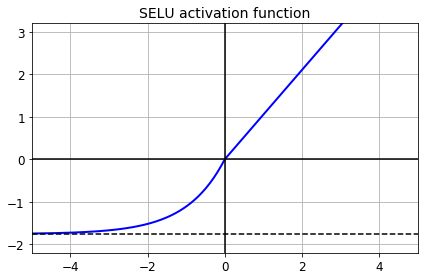

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

기본적으로 SELU 하이퍼파라미터(`scale`과 `alpha`)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정됩니다(입력은 평균이 0이고 표준 편차 1로 표준화되었다고 가정합니다). 이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지합니다. 이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있습니다:

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


쉽게 SELU를 사용할 수 있습니다:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

100개의 은닉층과 SELU 활성화 함수를 사용한 패션 MNIST를 위한 신경망을 만들어 보죠:

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

이제 훈련해 보죠. 입력을 평균 0과 표준 편차 1로 바꾸어야 한다는 것을 잊지 마세요:

In [29]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 32s 19ms/step - loss: 1.4254 - accuracy: 0.4457 - val_loss: 0.9036 - val_accuracy: 0.6758
Epoch 2/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.8673 - accuracy: 0.6903 - val_loss: 0.7675 - val_accuracy: 0.7316
Epoch 3/5
1719/1719 [==============================] - 32s 18ms/step - loss: 0.6920 - accuracy: 0.7525 - val_loss: 0.6481 - val_accuracy: 0.7694
Epoch 4/5
1719/1719 [==============================] - 32s 18ms/step - loss: 0.6801 - accuracy: 0.7533 - val_loss: 0.6137 - val_accuracy: 0.7852
Epoch 5/5
1719/1719 [==============================] - 32s 18ms/step - loss: 0.5883 - accuracy: 0.7845 - val_loss: 0.5503 - val_accuracy: 0.8036


대신 ReLU 활성화 함수를 사용하면 어떤 일이 일어나는지 확인해 보죠:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 19ms/step - loss: 1.8139 - accuracy: 0.2607 - val_loss: 1.4307 - val_accuracy: 0.3734
Epoch 2/5
1719/1719 [==============================] - 32s 19ms/step - loss: 1.1872 - accuracy: 0.4937 - val_loss: 1.0023 - val_accuracy: 0.5844
Epoch 3/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.9595 - accuracy: 0.6029 - val_loss: 0.8268 - val_accuracy: 0.6698
Epoch 4/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.9046 - accuracy: 0.6324 - val_loss: 0.8080 - val_accuracy: 0.6908
Epoch 5/5
1719/1719 [==============================] - 32s 19ms/step - loss: 0.8454 - accuracy: 0.6642 - val_loss: 0.7522 - val_accuracy: 0.7180


좋지 않군요. 그레이디언트 폭주나 소실 문제가 발생한 것입니다.

# 배치 정규화

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
bn1.updates

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[]

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.8750 - accuracy: 0.7123 - val_loss: 0.5525 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5753 - accuracy: 0.8031 - val_loss: 0.4724 - val_accuracy: 0.8476
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5189 - accuracy: 0.8205 - val_loss: 0.4375 - val_accuracy: 0.8546
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4827 - accuracy: 0.8322 - val_loss: 0.4152 - val_accuracy: 0.8594
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4565 - accuracy: 0.8408 - val_loss: 0.3997 - val_accuracy: 0.8636
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4398 - accuracy: 0.8472 - val_loss: 0.3867 - val_accuracy: 0.8700
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4242 - accuracy: 0.8511 - val_loss: 0.3762 - val_accuracy:

이따금 활성화 함수전에 BN을 적용해도 잘 동작합니다(여기에는 논란의 여지가 있습니다). 또한 `BatchNormalization` 층 이전의 층은 편향을 위한 항이 필요 없습니다. `BatchNormalization` 층이 이를 무효화하기 때문입니다. 따라서 필요 없는 파라미터이므로 `use_bias=False`를 지정하여 층을 만들 수 있습니다:

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0317 - accuracy: 0.6757 - val_loss: 0.6767 - val_accuracy: 0.7816
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6790 - accuracy: 0.7792 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5447 - accuracy: 0.8192 - val_loss: 0.4666 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5109 - accuracy: 0.8279 - val_loss: 0.4434 - val_accuracy: 0.8534
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4898 - accuracy: 0.8336 - val_loss: 0.4263 - val_accuracy: 0.8550
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4712 - accuracy: 0.8397 - val_loss: 0.4130 - val_accuracy:

## 그레이디언트 클리핑

모든 케라스 옵티마이저는 `clipnorm`이나 `clipvalue` 매개변수를 지원합니다:

In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전 훈련된 층 재사용하기

### 케라스 모델 재사용하기

패션 MNIST 훈련 세트를 두 개로 나누어 보죠:
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

검증 세트와 테스트 세트도 이렇게 나눕니다. 하지만 이미지 개수는 제한하지 않습니다.

A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 보겠습니다. A 작업에서 B 작업으로 약간의 지식이 전달되기를 기대합니다. 왜냐하면 A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷하기 때문입니다. 하지만 `Dense` 층을 사용하기 때문에 동일한 위치에 나타난 패턴만 재사용할 수 있습니다(반대로 합성곱 층은 훨씬 많은 정보를 전송합니다. 학습한 패턴을 이미지의 어느 위치에서나 감지할 수 있기 때문입니다. CNN 장에서 자세히 알아 보겠습니다).

In [46]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [53]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [54]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5927 - accuracy: 0.8103 - val_loss: 0.3894 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8785 - val_loss: 0.3286 - val_accuracy: 0.8834
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3011 - val_accuracy: 0.8984
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2974 - accuracy: 0.8975 - val_loss: 0.2895 - val_accuracy: 0.9018
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2835 - accuracy: 0.9020 - val_loss: 0.2774 - val_accuracy: 0.9071
Epoch 6/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2730 - accuracy: 0.9063 - val_loss: 0.2736 - val_accuracy: 0.9061
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2642 - accuracy: 0.9092 - val_loss: 0.2717 - val_accuracy:

In [55]:
model_A.save("my_model_A.h5")

In [56]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [57]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 42ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [60]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [61]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [62]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [63]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 39ms/step - loss: 0.5803 - accuracy: 0.6500 - val_loss: 0.5842 - val_accuracy: 0.6329
Epoch 2/4
7/7 [==============================] - 0s 16ms/step - loss: 0.5436 - accuracy: 0.6800 - val_loss: 0.5466 - val_accuracy: 0.6724
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.5066 - accuracy: 0.7300 - val_loss: 0.5144 - val_accuracy: 0.7099
Epoch 4/4
7/7 [==============================] - 0s 16ms/step - loss: 0.4749 - accuracy: 0.7500 - val_loss: 0.4855 - val_accuracy: 0.7312
Epoch 1/16
7/7 [==============================] - 0s 41ms/step - loss: 0.3964 - accuracy: 0.8100 - val_loss: 0.3461 - val_accuracy: 0.8631
Epoch 2/16
7/7 [==============================] - 0s 15ms/step - loss: 0.2799 - accuracy: 0.9350 - val_loss: 0.2603 - val_accuracy: 0.9260
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.2083 - accuracy: 0.9650 - val_loss: 0.2110 - val_accuracy: 0.9544
Epoch 4/16
7/7 [===============

마지막 점수는 어떤가요?

In [64]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [65]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9930


[0.0683005154132843, 0.9929999709129333]

훌륭하네요! 꽤 많은 정보를 전달했습니다: 오차율이 4배나 줄었네요!

In [66]:
(100 - 96.95) / (100 - 99.25)

4.066666666666663

# 고속 옵티마이저

## 모멘텀 옵티마이저

In [67]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## 네스테로프 가속 경사

In [68]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [69]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

In [70]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam 옵티마이저

In [71]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Adamax 옵티마이저

In [72]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam 옵티마이저

In [73]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## 학습률 스케줄링

### 거듭제곱 스케줄링

```lr = lr0 / (1 + steps / s)**c```
* 케라스는 `c=1`과 `s = 1 / decay`을 사용합니다

In [74]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [76]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4855 - accuracy: 0.8303 - val_loss: 0.4029 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3781 - accuracy: 0.8658 - val_loss: 0.3716 - val_accuracy: 0.8720
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3457 - accuracy: 0.8770 - val_loss: 0.3749 - val_accuracy: 0.8742
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3250 - accuracy: 0.8830 - val_loss: 0.3501 - val_accuracy: 0.8800
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3101 - accuracy: 0.8892 - val_loss: 0.3447 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2966 - accuracy: 0.8935 - val_loss: 0.3412 - val_accuracy: 0.8828
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2867 - accuracy: 0.8974 - val_loss: 0.3355 - val_accuracy:

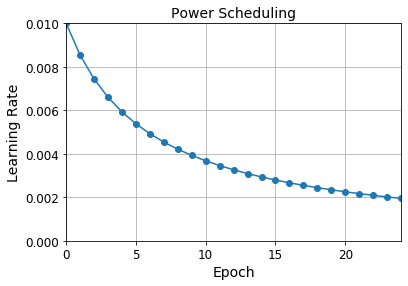

In [77]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케줄링

```lr = lr0 * 0.1**(epoch / s)```

In [78]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [79]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [80]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [81]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8717 - accuracy: 0.7511 - val_loss: 0.9296 - val_accuracy: 0.7502
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7778 - accuracy: 0.7756 - val_loss: 0.6632 - val_accuracy: 0.8124
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6531 - accuracy: 0.8051 - val_loss: 0.7064 - val_accuracy: 0.7834
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5903 - accuracy: 0.8228 - val_loss: 0.5971 - val_accuracy: 0.8258
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5431 - accuracy: 0.8379 - val_loss: 0.5389 - val_accuracy: 0.8488
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5012 - accuracy: 0.8489 - val_loss: 0.5297 - val_accuracy: 0.8562
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4695 - accuracy: 0.8578 - val_loss: 0.5339 - val_accuracy:

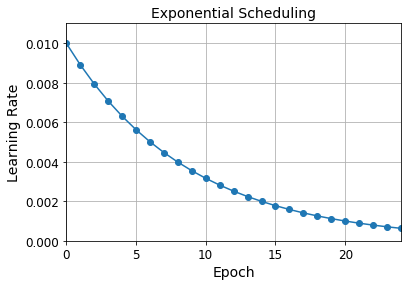

In [82]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

이 스케줄 함수는 두 번째 매개변수로 현재 학습률을 받을 수 있습니다:

In [83]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

에포크가 아니라 반복마다 학습률을 업데이트하려면 사용자 정의 콜백 클래스를 작성해야 합니다:

In [84]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7848 - accuracy: 0.7711 - val_loss: 0.8494 - val_accuracy: 0.7580
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6253 - accuracy: 0.8057 - val_loss: 0.7549 - val_accuracy: 0.7640
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5786 - accuracy: 0.8196 - val_loss: 0.6209 - val_accuracy: 0.8128
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5178 - accuracy: 0.8388 - val_loss: 0.5581 - val_accuracy: 0.8470
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4988 - accuracy: 0.8480 - val_loss: 0.5315 - val_accuracy: 0.8428
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4408 - accuracy: 0.8641 - val_loss: 0.4676 - val_accuracy: 0.8598
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4063 - accuracy: 0.8689 - val_loss: 0.6225 - val_accuracy:

In [85]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

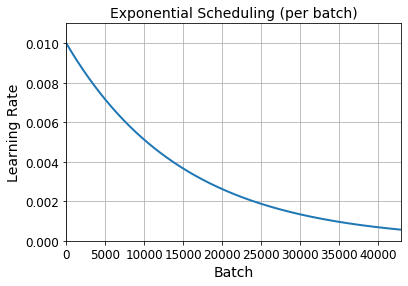

In [86]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 기간별 고정 스케줄링

In [87]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [88]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [89]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.8830 - accuracy: 0.7497 - val_loss: 1.0209 - val_accuracy: 0.7004
Epoch 2/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.9927 - accuracy: 0.6931 - val_loss: 0.8880 - val_accuracy: 0.7178
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8996 - accuracy: 0.7185 - val_loss: 1.0695 - val_accuracy: 0.6856
Epoch 4/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.9428 - accuracy: 0.7076 - val_loss: 0.9724 - val_accuracy: 0.7206
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.9195 - accuracy: 0.7078 - val_loss: 1.2058 - val_accuracy: 0.7076
Epoch 6/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6494 - accuracy: 0.7722 - val_loss: 0.6743 - val_accuracy: 0.7360
Epoch 7/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6002 - accuracy: 0.7929 - val_loss: 0.7192 - val_accuracy:

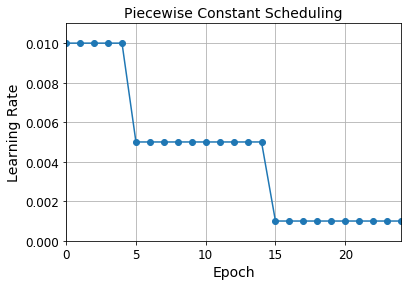

In [90]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 성능 기반 스케줄링

In [91]:
tf.random.set_seed(42)
np.random.seed(42)

In [92]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5882 - accuracy: 0.8079 - val_loss: 0.4696 - val_accuracy: 0.8538
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4975 - accuracy: 0.8391 - val_loss: 0.5668 - val_accuracy: 0.8406
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5165 - accuracy: 0.8419 - val_loss: 0.5295 - val_accuracy: 0.8496
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5144 - accuracy: 0.8454 - val_loss: 0.5411 - val_accuracy: 0.8480
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5096 - accuracy: 0.8496 - val_loss: 0.4733 - val_accuracy: 0.8490
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5276 - accuracy: 0.8515 - val_loss: 0.7935 - val_accuracy: 0.8416
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3111 - accuracy: 0.8925 - val_loss: 0.4018 - val_accuracy:

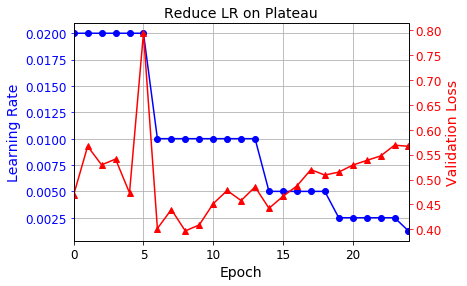

In [93]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras 스케줄러

In [94]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4894 - accuracy: 0.8277 - val_loss: 0.4096 - val_accuracy: 0.8592
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3820 - accuracy: 0.8650 - val_loss: 0.3742 - val_accuracy: 0.8700
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3487 - accuracy: 0.8767 - val_loss: 0.3736 - val_accuracy: 0.8686
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3265 - accuracy: 0.8838 - val_loss: 0.3496 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3105 - accuracy: 0.8899 - val_loss: 0.3434 - val_accuracy: 0.8800
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2959 - accuracy: 0.8950 - val_loss: 0.3415 - val_accuracy: 0.8808
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2855 - accuracy: 0.8987 - val_loss: 0.3354 - val_accuracy:

구간별 고정 스케줄링은 다음을 사용하세요:

In [95]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1사이클 스케줄링

In [96]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [97]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.3859    


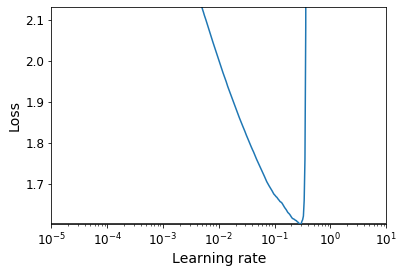

In [98]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [99]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [100]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8338
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4581 - accuracy: 0.8397 - val_loss: 0.4274 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4121 - accuracy: 0.8545 - val_loss: 0.4116 - val_accuracy: 0.8588
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.3870 - val_accuracy: 0.8686
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3639 - accuracy: 0.8717 - val_loss: 0.3765 - val_accuracy: 0.8676
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3457 - accuracy: 0.8774 - val_loss: 0.3742 - val_accuracy: 0.8708
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3634 - val_accuracy: 0.8704
Epoch 

# 규제를 사용해 과대적합 피하기

## $\ell_1$과 $\ell_2$ 규제

In [101]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 5ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [103]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 5ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


## 드롭아웃

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5838 - accuracy: 0.7998 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4209 - accuracy: 0.8443 - val_loss: 0.3406 - val_accuracy: 0.8724


## 알파 드롭아웃

In [105]:
tf.random.set_seed(42)
np.random.seed(42)

In [106]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6654 - accuracy: 0.7595 - val_loss: 0.5929 - val_accuracy: 0.8406
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5605 - accuracy: 0.7933 - val_loss: 0.5605 - val_accuracy: 0.8400
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5283 - accuracy: 0.8050 - val_loss: 0.4858 - val_accuracy: 0.8596
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5072 - accuracy: 0.8125 - val_loss: 0.4629 - val_accuracy: 0.8582
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4915 - accuracy: 0.8186 - val_loss: 0.4698 - val_accuracy: 0.8552
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4866 - accuracy: 0.8186 - val_loss: 0.4810 - val_accuracy: 0.8612
Epoch 7/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4724 - accuracy: 0.8251 - val_loss: 0.4792 - val_accuracy:

In [107]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4338 - accuracy: 0.8697


[0.4337695240974426, 0.869700014591217]

In [108]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.3243 - accuracy: 0.8887


[0.32432350516319275, 0.8887272477149963]

In [109]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.4167 - accuracy: 0.8463


## MC 드롭아웃

In [110]:
tf.random.set_seed(42)
np.random.seed(42)

In [111]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [112]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [113]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.43, 0.  , 0.18, 0.  , 0.39]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.75, 0.  , 0.25]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.42, 0.  , 0.  , 0.  , 0.58]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.26, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.07, 0.  , 0.8 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.3 , 0.  , 0.7 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.36, 0.  , 0.13, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.34, 0.  , 0.66]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.02, 0.  , 0.23]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.04, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.64, 0.  , 0.  , 0.  , 0.36]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.68, 0.  , 0.05, 0.  , 0.28]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.31, 0.  , 0.04, 0.  , 0

In [114]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.  , 0.09, 0.  , 0.68]],
      dtype=float32)

In [115]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.28, 0.  , 0.15, 0.  , 0.29]],
      dtype=float32)

In [116]:
y_pred = np.argmax(y_proba, axis=1)

In [117]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8666

In [118]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [119]:
tf.random.set_seed(42)
np.random.seed(42)

In [120]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [121]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [122]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [123]:
mc_model.set_weights(model.get_weights())

이제 MC 드롭아웃을 모델에 사용할 수 있습니다:

In [124]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.15, 0.  , 0.63]],
      dtype=float32)

## 맥스 노름

In [125]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [126]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4749 - accuracy: 0.8337 - val_loss: 0.3665 - val_accuracy: 0.8676
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3539 - accuracy: 0.8703 - val_loss: 0.3700 - val_accuracy: 0.8672


# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. CIFAR10에서 딥러닝

### a.
*문제: 100개의 뉴런을 가진 은닉층 20개로 심층 신경망을 만들어보세요(너무 많은 것 같지만 이 연습문제의 핵심입니다). He 초기화와 ELU 활성화 함수를 사용하세요.*

In [127]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*문제: Nadam 옵티마이저와 조기 종료를 사용하여 CIFAR10 데이터셋에 이 네트워크를 훈련하세요. `keras.datasets.cifar10.load_ data()`를 사용하여 데이터를 적재할 수 있습니다. 이 데이터셋은 10개의 클래스와 32×32 크기의 컬러 이미지 60,000개로 구성됩니다(50,000개는 훈련, 10,000개는 테스트). 따라서 10개의 뉴런과 소프트맥스 활성화 함수를 사용하는 출력층이 필요합니다. 모델 구조와 하이퍼파라미터를 바꿀 때마다 적절한 학습률을 찾아야 한다는 것을 기억하세요.*

모델에 출력층을 추가합니다:

In [128]:
model.add(keras.layers.Dense(10, activation="softmax"))

학습률 5e-5인 Nadam 옵티마이저를 사용해 보죠. 학습률 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2를 테스트하고 10번의 에포크 동안 (아래 텐서보드 콜백으로) 학습 곡선을 비교해 보았습니다. 학습률 3e-5와 1e-4가 꽤 좋았기 때문에 5e-5를 시도해 보았고 조금 더 나은 결과를 냈습니다.

In [129]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

CIFAR10 데이터셋을 로드하죠. 조기 종료를 사용하기 때문에 검증 세트가 필요합니다. 원본 훈련 세트에서 처음 5,000개를 검증 세트로 사용하겠습니다:

In [130]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170500096/170498071 [==============================] - 18s 0us/step


이제 콜백을 만들고 모델을 훈련합니다:

In [131]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [132]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
E0809 03:11:42.951561 139734898673472 program.py:312] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

In [133]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
   1/1407 [..............................] - ETA: 0s - loss: 165.9660 - accuracy: 0.0625WARNING:tensorflow:From /home/work/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1407/1407 [==============================] - 22s 16ms/step - loss: 4.0015 - accuracy: 0.1711 - val_loss: 2.0790 - val_accuracy: 0.2354
Epoch 2/100
1407/1407 [==============================] - 22s 16ms/step - loss: 2.0265 - accuracy: 0.2568 - val_loss: 2.0408 - val_accuracy: 0.2488
Epoch 3/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.9195 - accuracy: 0.2983 - val_loss: 1.9150 - val_accuracy: 0.2916
Epoch 4/100
1407/1407 [==============================] - 22s 15ms/step - loss: 1.8406 - accuracy: 0.3284 - val_loss: 1.9163 - val_accuracy: 0.3050
Epoch 5/100
1407/1407 [================

1407/1407 [==============================] - 22s 15ms/step - loss: 1.1599 - accuracy: 0.5818 - val_loss: 1.5514 - val_accuracy: 0.4658
Epoch 53/100
1407/1407 [==============================] - 22s 15ms/step - loss: 1.1511 - accuracy: 0.5853 - val_loss: 1.5512 - val_accuracy: 0.4798
Epoch 54/100
1407/1407 [==============================] - 22s 15ms/step - loss: 1.1485 - accuracy: 0.5887 - val_loss: 1.5754 - val_accuracy: 0.4648
Epoch 55/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.1398 - accuracy: 0.5905 - val_loss: 1.5335 - val_accuracy: 0.4806
Epoch 56/100
1407/1407 [==============================] - 22s 15ms/step - loss: 1.1352 - accuracy: 0.5909 - val_loss: 1.5603 - val_accuracy: 0.4732
Epoch 57/100
1407/1407 [==============================] - 22s 15ms/step - loss: 1.1285 - accuracy: 0.5933 - val_loss: 1.5535 - val_accuracy: 0.4824


In [134]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 1.5014 - accuracy: 0.0882


[1.5013599395751953, 0.08820000290870667]

가장 낮은 검증 손실을 내는 모델은 검증 세트에서 약 47% 정확도를 얻었습니다. 이 검증 점수에 도달하는데 39번의 에포크가 걸렸습니다. (GPU가 없는) 제 노트북에서 에포크당 약 10초 정도 걸렸습니다. 배치 정규화를 사용해 성능을 올릴 수 있는지 확인해 보죠.

### c.
*문제: 배치 정규화를 추가하고 학습 곡선을 비교해보세요. 이전보다 빠르게 수렴하나요? 더 좋은 모델이 만들어지나요? 훈련 속도에는 어떤 영향을 미치나요?*

다음 코드는 위의 코드와 배우 비슷합니다. 몇 가지 다른 점은 아래와 같습니다:

* 출력층을 제외하고 모든 `Dense` 층 다음에 (활성화 함수 전에) BN 층을 추가했습니다. 처음 은닉층 전에도 BN 층을 추가했습니다.
* 학습률을 5e-4로 바꾸었습니다. 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3를 시도해 보고 20번 에포크 후에 검증 세트 성능이 가장 좋은 것을 선택했습니다.
* run_logdir를 run_bn_* 으로 이름을 바꾸고 모델 파일 이름을 my_cifar10_bn_model.h5로 변경했습니다.

In [135]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 51s 36ms/step - loss: 1.8431 - accuracy: 0.3390 - val_loss: 1.7148 - val_accuracy: 0.3886
Epoch 2/100
1407/1407 [==============================] - 49s 35ms/step - loss: 1.6690 - accuracy: 0.4046 - val_loss: 1.6174 - val_accuracy: 0.4144
Epoch 3/100
1407/1407 [==============================] - 49s 35ms/step - loss: 1.5972 - accuracy: 0.4320 - val_loss: 1.5171 - val_accuracy: 0.4478
Epoch 4/100
1407/1407 [==============================] - 50s 35ms/step - loss: 1.5463 - accuracy: 0.4495 - val_loss: 1.4883 - val_accuracy: 0.4688
Epoch 5/100
1407/1407 [==============================] - 50s 35ms/step - loss: 1.5051 - accuracy: 0.4641 - val_loss: 1.4369 - val_accuracy: 0.4892
Epoch 6/100
1407/1407 [==============================] - 49s 35ms/step - loss: 1.4684 - accuracy: 0.4793 - val_loss: 1.4056 - val_accuracy: 0.5018
Epoch 7/100
1407/1407 [==============================] - 49s 35ms/step - loss: 1.4350 - accuracy: 0.4895 - val_loss: 1

[1.3183687925338745, 0.11540000140666962]

* *이전보다 빠르게 수렴하나요?* 훨씬 빠릅니다! 이전 모델은 가장 낮은 검증 손실에 도달하기 위해 39 에포크가 걸렸지만 BN을 사용한 새 모델은 18 에포크가 걸렸습니다. 이전 모델보다 두 배 이상 빠릅니다. BN 층은 훈련을 안정적으로 수행하고 더 큰 학습률을 사용할 수 있기 때문에 수렴이 빨라졌습니다.
* *BN이 더 좋은 모델을 만드나요?* 네! 최종 모델의 성능이 47%가 아니라 55% 정확도로 더 좋습니다. 이는 아주 좋은 모델이 아니지만 적어도 이전보다는 낫습니다(합성곱 신경망이 더 낫겠지만 이는 다른 주제입니다. 14장을 참고하세요).
* *BN이 훈련 속도에 영향을 미치나요?* 모델이 두 배나 빠르게 수렴했지만 각 에포크는 10초가 아니라 16초가 걸렸습니다. BN 층에서 추가된 계산 때문입니다. 따라서 전체적으로 에포크 횟수가 50% 정도 줄었지만 훈련 시간(탁상 시계 시간)은 30% 정도 줄었습니다. 결국 크게 향상되었습니다!

### d.
*문제: 배치 정규화를 SELU로 바꾸어보세요. 네트워크가 자기 정규화하기 위해 필요한 변경 사항을 적용해보세요(즉, 입력 특성 표준화, 르쿤 정규분포 초기화, 완전 연결 층만 순차적으로 쌓은 심층 신경망 등).*

In [136]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.9306 - accuracy: 0.3076 - val_loss: 1.8329 - val_accuracy: 0.3406
Epoch 2/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.7066 - accuracy: 0.3947 - val_loss: 1.7136 - val_accuracy: 0.3778
Epoch 3/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.6115 - accuracy: 0.4309 - val_loss: 1.6743 - val_accuracy: 0.3992
Epoch 4/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.5459 - accuracy: 0.4578 - val_loss: 1.6328 - val_accuracy: 0.4376
Epoch 5/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.4916 - accuracy: 0.4795 - val_loss: 1.6314 - val_accuracy: 0.4330
Epoch 6/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.4437 - accuracy: 0.4977 - val_loss: 1.5327 - val_accuracy: 0.4724
Epoch 7/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.4014 - accuracy: 0.5092 - val_loss: 1

[1.475338339805603, 0.12559999525547028]

In [137]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.4753 - accuracy: 0.1256


[1.475338339805603, 0.12559999525547028]

51.4% 정확도를 얻었습니다. 원래 모델보다 더 좋습니다. 하지만 배치 정규화를 사용한 모델만큼 좋지는 않습니다. 최고의 모델에 도달하는데 13 에포크가 걸렸습니다. 이는 원본 모델이나 BN 모델보다 더 빠른 것입니다. 각 에포크는 원본 모델처럼 10초만 걸렸습니다. 따라서 이 모델이 지금까지 가장 빠른 모델입니다(에포크와 탁상 시계 기준으로).

### e.
*문제: 알파 드롭아웃으로 모델에 규제를 적용해보세요. 그다음 모델을 다시 훈련하지 않고 MC 드롭아웃으로 더 높은 정확도를 얻을 수 있는지 확인해보세요.*

In [138]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 23s 17ms/step - loss: 1.8896 - accuracy: 0.3275 - val_loss: 1.7313 - val_accuracy: 0.3970
Epoch 2/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.6589 - accuracy: 0.4157 - val_loss: 1.7183 - val_accuracy: 0.3916
Epoch 3/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5727 - accuracy: 0.4479 - val_loss: 1.6073 - val_accuracy: 0.4364
Epoch 4/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5085 - accuracy: 0.4734 - val_loss: 1.5741 - val_accuracy: 0.4524
Epoch 5/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.4525 - accuracy: 0.4946 - val_loss: 1.5663 - val_accuracy: 0.4592
Epoch 6/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.4032 - accuracy: 0.5124 - val_loss: 1.5255 - val_accuracy: 0.4644
Epoch 7/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.3581 - accuracy: 0.5255 - val_loss: 1

[1.5026599168777466, 0.09139999747276306]

이 모델은 검증 세트에서 50.8% 정확도에 도달합니다. 드롭아웃이 없을 때보다(51.4%) 조금 더 나쁩니다. 하이퍼파라미터 탐색을 좀 많이 수행해 보면 더 나아 질 수 있습니다(드롭아웃 비율 5%, 10%, 20%, 40%과 학습률 1e-4, 3e-4, 5e-4, 1e-3을 시도했습니다). 하지만 이 경우에는 크지 않을 것 같습니다.

이제 MC 드롭아웃을 사용해 보죠. 앞서 사용한 `MCAlphaDropout` 클래스를 복사해 사용하겠습니다:

In [139]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

방금 훈련했던 모델과 (같은 가중치를 가진) 동일한 새로운 모델을 만들어 보죠. 하지만 `AlphaDropout` 층 대신 `MCAlphaDropout` 드롭아웃 층을 사용합니다:

In [140]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

그다음 몇 가지 유틸리티 함수를 추가합니다. 첫 번째 함수는 모델을 여러 번 실행합니다(기본적으로 10번). 그다음 평균한 예측 클래스 확률을 반환합니다. 두 번째 함수는 이 평균 확률을 사용해 각 샘플의 클래스를 예측합니다:

In [141]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

이제 검증 세트의 모든 샘플에 대해 예측을 만들고 정확도를 계산해 보죠:

In [142]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.497

이 경우에는 실제적인 정확도 향상이 없습니다(50.8%에서 50.9%).

따라서 이 연습문에서 얻은 최상의 모델은 배치 정규화 모델입니다.

### f.
*문제: 1사이클 스케줄링으로 모델을 다시 훈련하고 훈련 속도와 모델 정확도가 향상되는지 확인해보세요.*

In [143]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 2s 7ms/step - loss: nan - accuracy: 0.1399


[1e-05, 9.999868, 2.6130447387695312, 4.006446089063372]

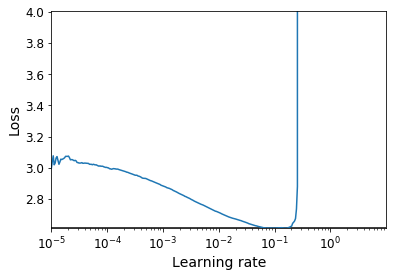

In [144]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [145]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [146]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 9ms/step - loss: 2.0537 - accuracy: 0.2843 - val_loss: 1.7811 - val_accuracy: 0.3744
Epoch 2/15
352/352 [==============================] - 3s 7ms/step - loss: 1.7635 - accuracy: 0.3765 - val_loss: 1.6431 - val_accuracy: 0.4252
Epoch 3/15
352/352 [==============================] - 3s 7ms/step - loss: 1.6241 - accuracy: 0.4217 - val_loss: 1.6001 - val_accuracy: 0.4368
Epoch 4/15
352/352 [==============================] - 3s 7ms/step - loss: 1.5434 - accuracy: 0.4520 - val_loss: 1.6114 - val_accuracy: 0.4310
Epoch 5/15
352/352 [==============================] - 3s 7ms/step - loss: 1.4914 - accuracy: 0.4710 - val_loss: 1.5895 - val_accuracy: 0.4434
Epoch 6/15
352/352 [==============================] - 3s 7ms/step - loss: 1.4510 - accuracy: 0.4818 - val_loss: 1.5678 - val_accuracy: 0.4506
Epoch 7/15
352/352 [==============================] - 3s 7ms/step - loss: 1.4143 - accuracy: 0.4979 - val_loss: 1.6717 - val_accuracy: 0.4294
Epoch 

1사이클 방식을 사용해 모델을 15에포크 동안 훈련했습니다. (큰 배치 크기 덕분에) 각 에포크는 3초만 걸렸습니다. 이는 지금까지 훈련한 가장 빠른 모델보다 3배나 더 빠릅니다. 또한 모델 성능도 올라갔습니다(50.8%에서 52.8%). 배치 정규화 모델이 조금 더 성능이 높지만 훈련 속도가 더 느립니다.